# � Convolutie: Van Snapchatfilters tot beeldbewerking

Welkom bij deze workshop over **convoluties** - de geheime kracht achter Snapchat filters, Instagram effecten, en nog veel meer! 

## 🤳 Wat ga je leren?

In deze workshop ontdek je hoe computers beelden kunnen bewerken en effecten kunnen maken:
- 📸 Hoe Snapchat en Instagram hun filters maken
- 🔍 Patronen herkennen in foto's (lijnen, randen, vormen)
- ✨ Je eigen foto-effecten creëren
- 🎨 Experimenteren met je eigen foto's!

## 🚀 Hoe werkt dit?

Dit bestand is een *Jupyter Notebook* - een digitaal werkboek waar je zelf kunt experimenteren! Je kunt de grijze vakjes met code laten draaien door erop te klikken en dan **Shift + Enter** te drukken.

**⚠️ BELANGRIJK:** Begin met het draaien van de cel hieronder, anders werkt niets!

In [ ]:
# 📦 Alle tools laden die we nodig hebben voor beeldbewerking!
# Dit is zoals het uitpakken van een gereedschapskist

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from PIL import Image
from IPython.display import display, clear_output
import io
import base64

# Voor het uploaden van eigen foto's
print("🔧 Installeren van file upload tools...")
try:
    from google.colab import files
    IN_COLAB = True
    print("✅ Google Colab gedetecteerd - file upload beschikbaar!")
except ImportError:
    IN_COLAB = False
    print("💻 Lokale omgeving gedetecteerd")

print("✅ Alles klaar! Laten we beginnen met beeldeffecten!")

🔧 Installeren van file upload tools...
💻 Lokale omgeving gedetecteerd
🔧 Installeren van beeldbewerking tools...
✅ SimpleITK geïnstalleerd!
✅ Alles klaar! Laten we beginnen met beeldeffecten!


# � Hoe werken Snapchat filters eigenlijk?

Heb je je ooit afgevraagd hoe Snapchat, Instagram en TikTok filters maken? Het geheim zit in **convoluties**!

## 🎭 Voorbeelden van convolutie-effecten:
- **🔍 Edge Detection:** Vind randen van objecten (voor gezichtsherkenning)
- **🌟 Blur Effect:** Wazig maken van de achtergrond
- **✨ Sharpen:** Foto's scherper maken
- **🎨 Artistic Filters:** Van foto naar tekening
- **🌈 Color Effects:** Kleuren veranderen en effecten

## 🧠 Hoe werkt dit:
Elke filter is eigenlijk een wiskundige operatie die over je foto "schuift" en elk pixel aanpast op basis van zijn buren. Net zoals een penseel over een canvas.

**Fun fact:** Je telefoon doet duizenden van deze berekeningen per seconde om real-time filters te maken! 🤯

## 🖼️ Hoe "ziet" een computer eigenlijk een foto?

Voor jou is een foto gewoon een foto van je vrienden, huisdier, of landschap. Maar voor een computer is het heel anders.

**Voor mensen:** 👁️ Wij zien gezichten, objecten, kleuren, emoties  
**Voor computers:** 🔢 Een computer ziet alleen maar getallen in een raster

### 📱 Van selfie naar Ggtallen:
Wanneer je een selfie maakt, gebeurt dit:
1. **Capture:** Camera vangt licht op
2. **Digitize:** Het beeld wordt omgezet in heel veel kleine puntjes (pixels)
3. **Store:** Elk puntje krijgt een getal voor helderheid/kleur
4. **Display:** Getallen worden weer omgezet naar een afbeelding op je scherm

### 🎨 Pixeltypes:
- **Zwart-wit foto:** 1 getal per pixel (0 = zwart, 255 = wit)
- **Kleurenfoto:** 3 getallen per pixel (Rood, Groen, Blauw)

**Fun fact:** Een typische smartphonefoto heeft ongeveer 12 miljoen pixels! 📱

In [ ]:
# 🛠️ Handige functies voor beeldbewerking

def open_img(path):
    """Open een afbeelding van verschillende formaten"""
    try:
        if path.endswith('.png') or path.endswith('.jpg') or path.endswith('.jpeg'):
            return np.array(Image.open(path).convert('L'))
        elif path.endswith('.mhd'):
            return sitk.GetArrayFromImage(sitk.ReadImage(path))[32,:,:]
    except:
        print(f"❌ Kon {path} niet openen")
        return None

def visualize(img, title="Afbeelding", clim=None):
    """Laat een afbeelding mooi zien"""
    plt.figure(figsize=(8, 6))
    if clim:
        plt.imshow(img, cmap='gray', clim=clim)
    else:
        plt.imshow(img, cmap='gray')
    plt.title(title, fontsize=14)
    plt.axis('off')
    plt.show()

def create_sample_image():
    """Maak een simpele testafbeelding als we geen andere hebben"""
    # Maak een simpel patroon
    img = np.zeros((100, 100))
    img[20:80, 20:40] = 255  # Witte rechthoek
    img[20:40, 60:80] = 255  # Nog een witte rechthoek
    img[60:80, 60:80] = 255  # En nog een
    # Voeg wat lijnen toe
    img[10, :] = 255  # Horizontale lijn
    img[:, 10] = 255  # Verticale lijn
    return img

def resize_image_smart(img, max_pixels=50000):
    """
    Verkleint afbeeldingen die te groot zijn voor snellere verwerking
    
    Parameters:
    - img: De originele afbeelding
    - max_pixels: Maximum aantal pixels (standaard 50.000 = ongeveer 224x224)
    
    Returns:
    - Verkleinde afbeelding
    """
    height, width = img.shape
    current_pixels = height * width
    
    if current_pixels <= max_pixels:
        print(f"📏 Afbeelding is al klein genoeg ({current_pixels:,} pixels)")
        return img
    
    # Bereken nieuwe afmetingen met behoud van aspect ratio
    scale_factor = np.sqrt(max_pixels / current_pixels)
    new_height = int(height * scale_factor)
    new_width = int(width * scale_factor)
    
    # Gebruik PIL voor high-quality resizing
    pil_img = Image.fromarray(img.astype('uint8'))
    resized_pil = pil_img.resize((new_width, new_height), Image.Resampling.LANCZOS)
    resized_img = np.array(resized_pil)
    
    print(f"📏 Afbeelding verkleind van {height}x{width} ({current_pixels:,} pixels)")
    print(f"   naar {new_height}x{new_width} ({new_height*new_width:,} pixels)")
    print(f"   💡 Dit maakt de filters {current_pixels/(new_height*new_width):.1f}x sneller!")
    
    return resized_img
    
print("🎨 Beeldbewerkingsfuncties geladen!")

🎨 Beeldbewerkingsfuncties geladen!


## 📸 Upload je eigen foto

Je kunt je eigen foto uploaden om mee te experimenteren. De foto wordt automatisch naar zwart-wit omgezet zodat je er convoluties op kunt toepassen.

### 🎯 Tips voor de beste resultaten:
- Gebruik foto's met duidelijke lijnen en randen
- Gezichten werken goed (voor edge detection)
- Gebouwen en objecten zijn ook perfect
- Niet te grote bestanden (max 5MB)

**Klik op de cel hieronder om je foto te uploaden!** 📤

🎬 Klaar om je foto te uploaden!
💻 File upload werkt alleen in Google Colab
📁 Je kunt wel een lokaal bestand pad opgeven in de volgende cel

🎨 Geen probleem! We gebruiken een test-afbeelding om mee te oefenen:


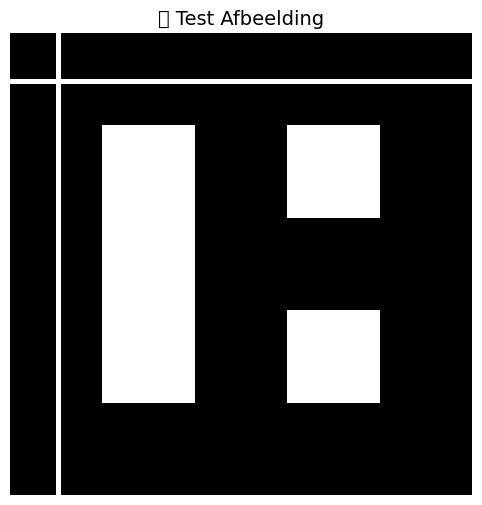

In [ ]:
# 📸 Upload en verwerk je eigen foto!

def upload_and_process_image():
    """Upload een foto en zet hem om naar zwart-wit voor convolutie experimenten"""
    
    if IN_COLAB:
        print("📤 Klik op 'Choose Files' om je foto te uploaden...")
        uploaded = files.upload()
        
        if uploaded:
            # Neem de eerste geüploade foto
            filename = list(uploaded.keys())[0]
            print(f"✅ Foto '{filename}' succesvol geüpload!")
            
            try:
                # Open en converteer naar zwart-wit
                img = Image.open(io.BytesIO(uploaded[filename]))
                img_gray = np.array(img.convert('L'))
                
                print(f"🔄 Foto omgezet naar zwart-wit ({img_gray.shape[0]}x{img_gray.shape[1]} pixels)")
                
                # Verklein de afbeelding voor betere performance
                img_gray = resize_image_smart(img_gray, max_pixels=50000)
                
                # Laat de originele en verwerkte versie zien
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
                
                ax1.imshow(img)
                ax1.set_title("📸 Originele Foto")
                ax1.axis('off')
                
                ax2.imshow(img_gray, cmap='gray')
                ax2.set_title("⚫⚪ Zwart-Wit Versie (Verkleind)")
                ax2.axis('off')
                
                plt.tight_layout()
                plt.show()
                
                return img_gray
                
            except Exception as e:
                print(f"❌ Fout bij verwerken foto: {e}")
                return None
        else:
            print("❌ Geen foto geüpload")
            return None
    else:
        print("💻 File upload werkt alleen in Google Colab")
        print("📁 Je kunt wel een lokaal bestand pad opgeven in de volgende cel")
        return None

# Probeer een foto te uploaden
print("🎬 Klaar om je foto te uploaden!")
user_image = upload_and_process_image()

# Als uploaden niet lukt, gebruiken we een voorbeeldafbeelding
if user_image is None:
    print("\n🎨 Geen probleem! We gebruiken een test-afbeelding om mee te oefenen:")
    user_image = create_sample_image()
    visualize(user_image, "🧪 Test Afbeelding")

['C:\\Users\\StegehuisC\\surfdrive\\Documents\\Github\\machine_learning_medical_data_workshop\\chess.jpg']
C:\Users\StegehuisC\surfdrive\Documents\Github\machine_learning_medical_data_workshop\chess.jpg
✅ Afbeelding geladen van: C:\Users\StegehuisC\surfdrive\Documents\Github\machine_learning_medical_data_workshop\chess.jpg
['C:\\Users\\StegehuisC\\surfdrive\\Documents\\Github\\machine_learning_medical_data_workshop\\chess.jpg']
C:\Users\StegehuisC\surfdrive\Documents\Github\machine_learning_medical_data_workshop\chess.jpg
✅ Afbeelding geladen van: C:\Users\StegehuisC\surfdrive\Documents\Github\machine_learning_medical_data_workshop\chess.jpg

📐 Afbeelding informatie:
   Grootte: 427 x 640 pixels
   Totaal pixels: 273,280


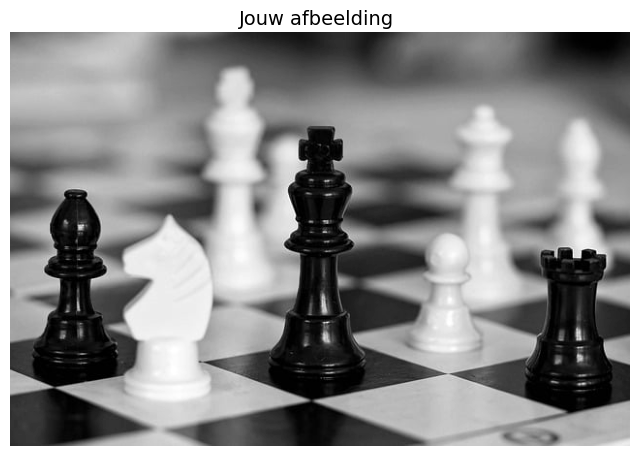


🎯 Perfect! Nu kunnen we gaan experimenteren met convoluties!


In [ ]:
# 🎨 Alternatief: Lokaal bestand of online foto

def load_alternative_image():
    """Laad een alternatieve afbeelding als uploaden niet werkt"""
    
    # Probeer een lokaal bestand (gebruikers kunnen dit aanpassen)
    local_paths = [
        "test_image.jpg",  # Vervang dit door een bestaand lokaal bestand
        #"foto.jpg",  # Gebruikers kunnen hun foto hier neerzetten
        #"image.png",
        #"/content/machine_learning_medical_data_workshop/TEV1P1CTI.mhd"  # Fallback
    ]

    print(local_paths)
    for path in local_paths:
        img = open_img(path)
        print(path)
        if img is not None:
            print(f"✅ Afbeelding geladen van: {path}")
            # Verkleien de afbeelding automatisch voor betere performance
            img = resize_image_smart(img, max_pixels=50000)
            return img
    
    # Als alles faalt, maak een testafbeelding
    print("🎨 Maken van een testafbeelding...")
    return create_sample_image()

# Gebruik de geüploade foto, of laad een alternatief
if 'user_image' not in globals() or user_image is None:
    img = load_alternative_image()
else:
    img = user_image
    print("📸 Gebruiken van je geüploade foto!")

print(f"\n📐 Afbeelding informatie:")
print(f"   Grootte: {img.shape[0]} x {img.shape[1]} pixels")
print(f"   Totaal pixels: {img.shape[0] * img.shape[1]:,}")

# Laat de afbeelding zien
visualize(img, "Jouw afbeelding ")

print("\n🎯 Perfect! Nu kunnen we gaan experimenteren met convoluties!")

## 🔍 Onderzoek: Hoeveel pixels zitten er in jouw foto?

Net zoals een LEGO-bouwwerk uit LEGO-steentjes bestaat, bestaat een digitale foto uit pixels - kleine, vierkante blokjes. Laten we eens kijken hoeveel "bouwsteentjes" jouw foto heeft.

In [ ]:
# 🧮 Pixels tellen:  Hoeveel bouwsteentjes heeft jouw foto?

print("📐 De afmetingen van jouw foto zijn:")
vorm = np.shape(img)
print(f"   Hoogte: {vorm[0]} pixels")
print(f"   Breedte: {vorm[1]} pixels")

# Bereken het totale aantal pixels
totaal_pixels = vorm[0] * vorm[1]
print(f"\n🎯 Totaal aantal pixels: {totaal_pixels:,}")

# Geef wat context
if totaal_pixels > 1000000:
    print(f"   🤯 Dat zijn meer dan 1 miljoen pixels")
elif totaal_pixels > 100000:
    print(f"   🎉 Dat zijn meer dan 100 duizend pixels")
else:
    print(f"   👍 Een mooie overzichtelijke foto om mee te experimenteren!")

# Vergelijk met bekende dingen
megapixels = totaal_pixels / 1000000
print(f"   📱 Dit is ongeveer {megapixels:.1f} megapixels")

print(f"\n💭 De computer moet al deze {totaal_pixels:,} getallen analyseren om filters toe te passen.")
print("   Gelukkig zijn computers daar heel snel in.")

📐 De afmetingen van jouw foto zijn:
   Hoogte: 427 pixels
   Breedte: 640 pixels

🎯 Totaal aantal pixels: 273,280
   🎉 Dat zijn meer dan 100 duizend pixels
   📱 Dit is ongeveer 0.3 megapixels

💭 De computer moet al deze 273,280 getallen analyseren om filters toe te passen.
   Gelukkig zijn computers daar heel snel in.


## 🎭 Covoluties: Hoe filters werken

**Plot twist:** Die Snapchat filters die je gebruikt? Die werken allemaal met **convoluties**! 🤳

### 🔍 Wat is een convolutie?
Stel je voor dat je een magisch vergrootglas hebt dat over je foto schuift. Op elke plek kijkt het vergrootglas naar een klein gebied (bijvoorbeeld 3x3 pixels) en past een wiskundig trucje toe om dat gebied te veranderen.

### 🎨 Populaire Filter-Types:
- **🌟 Blur (Waas):** Voor die dreamy achtergrond-effecten
- **⚡ Sharpen:** Maak alles super scherp en duidelijk  
- **🔍 Edge Detection:** Vind alle randen (gebruikt in gezichtsherkenning!)
- **🎭 Emboss:** Geef je foto een 3D-effect
- **🌈 Artistic:** Zet je foto om in een kunstwerk

![Convolutie Animatie](https://upload.wikimedia.org/wikipedia/commons/0/04/Convolution_arithmetic_-_Padding_strides.gif?20190413174630)

### 🕵️ Hoe het eerkt:
1. **Kernel:** Een kleine tabel met getallen (het "recept" voor het effect)
2. **Schuiven:** De kernel schuift over elke pixel van je foto
3. **Berekening:** Op elke plek wordt een wiskundige bewerking gedaan
4. **Resultaat:** Je krijgt een nieuwe foto met het effect!

### 📱 Toepassingen:
- **Snapchat/Instagram:** Real-time face filters
- **Fotografie:** Automatische verbetering van foto's
- **Gaming:** Visual effects en graphics
- **Zelfrijdende auto's:** Herkenning van verkeersborden en lijnen

**Ready om je eigen filters te maken?** 🚀

In [28]:
# 🎬 Convolutie: filters maken

def apply_conv(image, kernel, iter=1, title_prefix="Filter Effect"):
    """
    Past een convolutie toe op een afbeelding. Dit is de motor achter alle filters.
    
    Parameters:
    - image: De foto om te bewerken
    - kernel: Het "recept" voor het effect
    - iter: Hoe vaak het effect toegepast wordt
    - title_prefix: Naam van het effect
    """
    image, kernel = torch.from_numpy(image).float(), torch.from_numpy(kernel).float()
    img_shape, kernel_shape = image.shape, kernel.shape
    
    # Bepaal automatisch een goede clim op basis van de afbeelding
    original_min, original_max = image.min().item(), image.max().item()
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    print(f" {title_prefix} wordt toegepast...")
    print(f"   Kernel: {kernel_shape[0]}x{kernel_shape[1]}")
    print(f"   Iteraties: {iter}")
    
    for level in range(iter):
        # Pas convolutie toe
        image = F.conv2d(image.reshape(1, 1, img_shape[0], img_shape[1]),
                         kernel.reshape(1, 1, kernel_shape[0], kernel_shape[1]),
                         padding='same').squeeze()
        
        # Update de display
        ax.clear()
        ax.imshow(image.numpy(), cmap='gray', clim=[original_min, original_max])
        ax.set_title(f' {title_prefix} - Stap {level+1}/{iter}', fontsize=16)
        ax.axis('off')
        
        display(fig)
        clear_output(wait=True)
        plt.pause(0.2)
    
    plt.close()
    print(f"🎉 {title_prefix} voltooid!")
    
    if iter>1:
        # Laat het eindresultaat nog een keer zien
        final_result = image.numpy()
        visualize(final_result, f"Eindresultaat: {title_prefix}")
    
    return image.numpy()

def show_kernel(kernel, title="Kernel"):
    """Laat een kernel mooi zien"""
    plt.figure(figsize=(6, 4))
    plt.imshow(kernel, cmap='RdBu_r', interpolation='nearest')
    plt.title(f"🔧 {title}")
    plt.colorbar(label='Waarde')
    
    # Voeg getallen toe aan elke cel
    for i in range(kernel.shape[0]):
        for j in range(kernel.shape[1]):
            plt.text(j, i, f'{kernel[i, j]:.1f}', 
                    ha='center', va='center', fontsize=12, fontweight='bold')
    plt.show()

print("🎬 Klaar om effecten te maken!")

🎬 Klaar om effecten te maken!


## 🎮 Experiment 1: Teleportatiefilter

**Eerste experiment:** We gaan je foto laten "teleporteren"! Deze filter verschuift alle pixels naar links - alsof je foto langzaam naar links beweegt.

Dit principe wordt gebruikt in:
- **Bewegende effecten** (zoals glitter die over je gezicht beweegt)
- **Morphing filters** (gezichtsveranderingen)
- **Animaties** in stories

### 🎯 Let Op:
- Wat gebeurt er met de pixels aan de rechterkant?
- Zie je hoe de foto langzaam "verdwijnt"?

**Klaar voor teleportatie?** 

🎉 Teleportatie-effect voltooid!


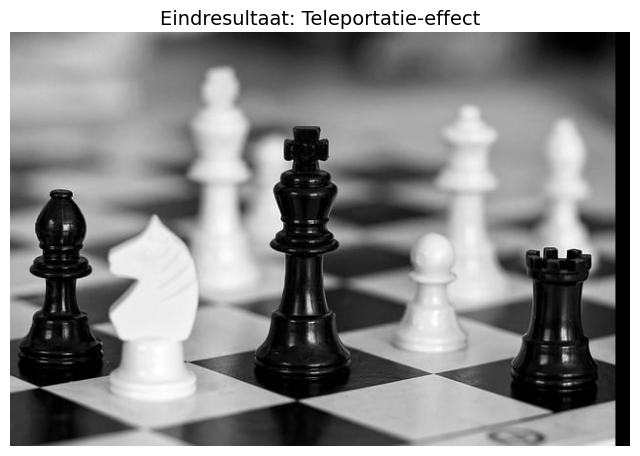


🤯 Je foto is naar links geteleporteerd!
💡 Dit is hetzelfde principe als bewegende Snapchat filters


In [ ]:
# 🎯 Teleportatiefilter, links

print("🔧 Maken van de Teleportatiekernel...")
print("   Dit effect verschuift elke pixel één plaats naar links")

# De teleportatie kernel
teleport_kernel = np.array([[0, 0, 0],    # Bovenste rij: negeer
                           [0, 0, 1],    # Middelste rij: kopieer van rechts
                           [0, 0, 0]])   # Onderste rij: negeer

print("\n🧠 Hoe het werkt:")
print("   - De '1' staat rechts, dus elke pixel wordt naar links gekopieerd")
print("   - Hierdoor schuift de hele foto naar links")

# Laat de kernel zien
show_kernel(teleport_kernel, "Teleportatiekernel")

print("\n🎬 3... 2... 1... TELEPORTATIE! ✨")

# Pas het 15 keer toe voor een smooth effect
result = apply_conv(img, teleport_kernel, iter=15, title_prefix="Teleportatie-effect")

print("\n🤯 Je foto is naar links geteleporteerd!")
print("💡 Dit is hetzelfde principe als bewegende Snapchat filters")

## 🎮 Experiment 2: Anti-Gravity Filter

**Tweede experiment:** Nu gaan we je foto laten zweven! Dit filter tilt alle pixels omhoog.

### 📱 Instagram:
Deze techniek zie je in:
- **Rising text effects** (tekst die omhoog zweeft)
- **Floating object filters** (objecten die in de lucht hangen)
- **Levitation effects** (alsof dingen zweven)

### 🏆 JOUW UITDAGING:
Na dit experiment: **kun jij een filter maken die de foto schuin laat bewegen?** (bijvoorbeeld naar rechts-onder)

**Hint:** Bedenk waar je de '1' in de kernel moet zetten! 🤔

🎉 Anti-Gravity Effect voltooid!


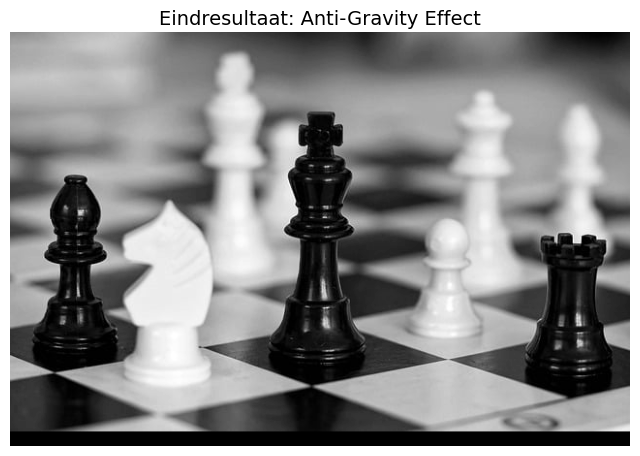


✨ Je foto zweeft omhoog
🎯 Zie je het patroon? De positie van '1' bepaalt de bewegingsrichting.

💡 Probeer nu een kernel te maken voor schuine beweging door de getallen in antigrav_kernel aan te passen.


In [13]:
# 🚁 Omhoog zweven

print("🔧 Maken van de Anti-Gravity Kernel...")
print("   Deze filter laat elke pixel omhoog zweven zoals een ballon 🎈")

# De anti-gravity kernel
antigrav_kernel = np.array([[0, 0, 0],    # Bovenste rij: negeer
                           [0, 0, 0],    # Middelste rij: negeer  
                           [0, 1, 0]])   # Onderste rij: kopieer naar boven

print("\n🧠 De magie:")
print("   - De '1' staat onderaan, dus pixels worden omhoog gekopieerd")

# Laat de kernel zien
show_kernel(antigrav_kernel, "Anti-Gravity Kernel")

print("\n🎬 Zwaartekracht uit... 3... 2... 1... ZWEVEN! 🎈")

# Pas het toe met een leuke naam
result = apply_conv(img, antigrav_kernel, iter=15, title_prefix="Anti-Gravity Effect")

print("\n✨ Je foto zweeft omhoog")
print("🎯 Zie je het patroon? De positie van '1' bepaalt de bewegingsrichting.")
print("\n💡 Probeer nu een kernel te maken voor schuine beweging door de getallen in antigrav_kernel aan te passen.")

## 🐎 SUPERUITDAGING: De paardensprong

Heb je wel eens schaak gespeeld? Een paard beweegt in een L-vorm: 2 vakjes in één richting, dan 1 vakje opzij.

### 🎯 Jouw missie:
Maak een 5×5 kernel die de foto een **paardensprong** laat maken:
- 2 pixels omhoog
- 1 pixel naar links

**Hint:** 🤫 
- Alle vakjes in de kernel zijn 0, behalve ÉÉN vakje
- Dat ene vakje moet een 1 worden
- Denk goed na waar je die 1 neerzet!

**Extra uitdaging:** Kun je ook andere schaakstukken namaken? Een toren (recht), een loper (schuin)?

### 🎮 Toepassing in social media:
Deze complexe bewegingspatronen zie je in:
- **TikTok transition effects**
- **Advanced Instagram story animations**  
- **Gaming filters** die objecten laten "springen"


🎉 Filter Effect voltooid!


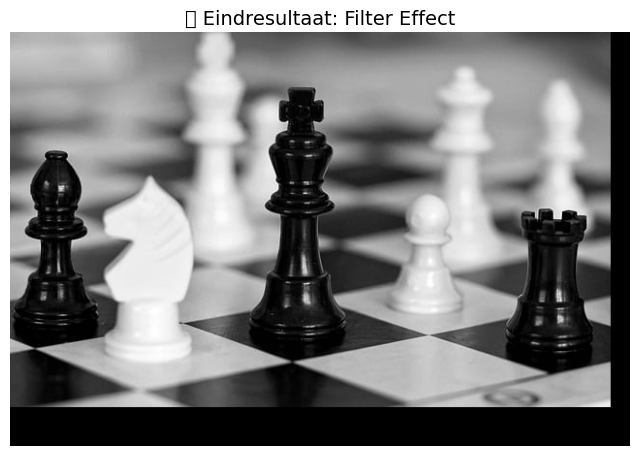


🤔 Lukte het? Als de foto niet bewoog, probeer dan een andere plek!
💡 Tip: denk aan de kernel als een kaart: waar wil je dat de pixel naartoe gaat?


In [ ]:
# 🐎 Jouw Paardensprong Kernel - Kun jij het oplossen?

print("🏁 Dit is jouw uitdaging! Verander de kernel hieronder:")
print("   Zet een '1' op de juiste plek om een paardensprong te maken!")
print("   (2 omhoog, 1 naar links)")

# VERANDER DEZE KERNEL - zet ergens een 1 neer!
kernel = np.array([[0, 0, 0, 0, 0],    # Rij 1
                   [0, 0, 0, 0, 0],    # Rij 2  
                   [0, 0, 0, 0, 0],    # Rij 3 (midden)
                   [0, 0, 0, 0, 0],    # Rij 4
                   [0, 0, 0, 0, 0]])   # Rij 5

print("\n🎬 Laten we kijken wat jouw kernel doet:")

n_iters = 20
apply_conv(img, kernel, n_iters)

print("\n🤔 Lukte het? Als de foto niet bewoog, probeer dan een andere plek!")
print("💡 Tip: denk aan de kernel als een kaart: waar wil je dat de pixel naartoe gaat?")

## � Experiment 3: Blur (waas)

**Populair filter!** Deze kernel maakt je foto waziger en geeft een dromerig, zacht effect, precies zoals Instagram en Snapchatfilters.

### 📱 Waar zie je dit:
- **Portrait mode** achtergrondvervaging
- **Beauty filters** voor zachte huid
- **Dreamy/ethereal** fotoeffecten  
- **Background blur** in videobellen
- **Bokeh effect** simulatie

### 🤓 Hoe werkt het?
In plaats van pixels te verplaatsen, neemt deze kernel het **gemiddelde** van een pixel en al zijn buren. Dus:
- Scherpe randen worden zacht
- Details vervagen
- De foto krijgt een zachte, professionele uitstraling

### 🔬 Experimenttijd
Na het effect: probeer de getallen in de kernel te veranderen. Wat gebeurt er dan?

🎉 Instagram Blur voltooid!


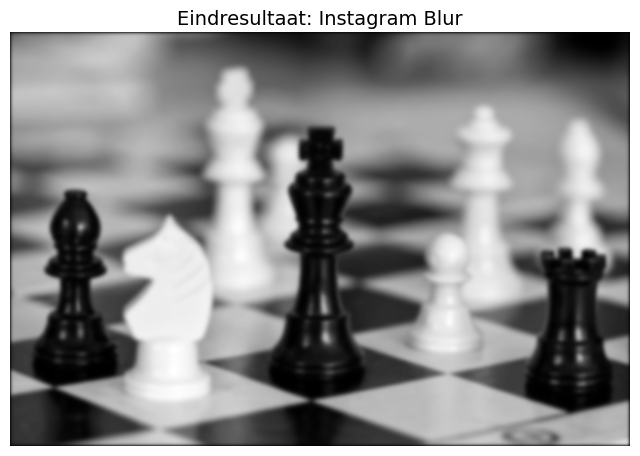

🎯 Dit is hetzelfde principe als:
   • Portrait mode op iPhones
   • Beauty filters op Snapchat
   • Zoom background blur

🔬 EXPERIMENT: Verander de getallen in de blur_kernel hierboven!
   • Maak de 4 groter voor meer blur
   • Maak alles kleiner voor subtielere effecten


In [20]:
# Instagram Blur Filter

print("Maken van de Instagram Blur Kernel...")
print("   Deze kernel creëert een 'soft focus' look")

# Professional blur kernel - gebaseerd op Gaussian blur
blur_kernel = np.array([[1, 2, 1],     # Hoeken tellen minder mee (1)
                       [2, 4, 2],     # Zijkanten tellen meer mee (2)  
                       [1, 2, 1]]) / 16  # Midden telt het zwaarst (4), delen door 16

print(f"   • Alle getallen samen = 16")
print(f"   • Daarom delen we door 16 → gemiddelde berekening")
print(f"   • Elk pixel wordt vervangen door het gewogen gemiddelde van zijn buurt")

# Laat de kernel zien
show_kernel(blur_kernel * 16, "Blurkernel (×16 voor visualisatie)")

print("\n🎬 Applying Instagram-style blur... ✨")

# Pas meerdere keren toe voor een sterker effect
result = apply_conv(img, blur_kernel, iter=8, title_prefix="Instagram Blur")

print("🎯 Dit is hetzelfde principe als:")
print("   • Portrait mode op iPhones")
print("   • Beauty filters op Snapchat")  
print("   • Zoom background blur")

print("\n🔬 EXPERIMENT: Verander de getallen in de blur_kernel hierboven!")
print("   • Maak de 4 groter voor meer blur")
print("   • Maak alles kleiner voor subtielere effecten")

## �️ Experiment 4: Gezichtsherkenning

Deze kernel is het geheime ingrediënt achter gezichtsherkenning! Het vindt **randen** in foto's - precies hoe Snapchat weet waar je neus, ogen en mond zijn!

Deze lijndetectie wordt gebruikt in:
- **👻 Snapchat face filters** (hond oren, gezicht swap)
- **📸 Camera autofocus** (vindt belangrijke objecten)
- **🚗 Zelfrijdende auto's** (detecteert verkeersborden, lijnen)
- **🔒 Face unlock** op telefoons
- **🎮 Motion capture** in games

### 🕵️ Hoe werkt het?
- **+1 waarden:** "Zoek naar lichte gebieden hier"
- **-1 waarden:** "Zoek naar donkere gebieden hier"  
- **0 waarden:** "Dit boeit me niet"

**Waarom werkt het:** Randen hebben altijd een lichte kant en een donkere kant naast elkaar

### 🏆 UITDAGING:
**Kun jij een kernel maken die horizontale randen vindt?** (zoals de lijn van iemands lippen?)

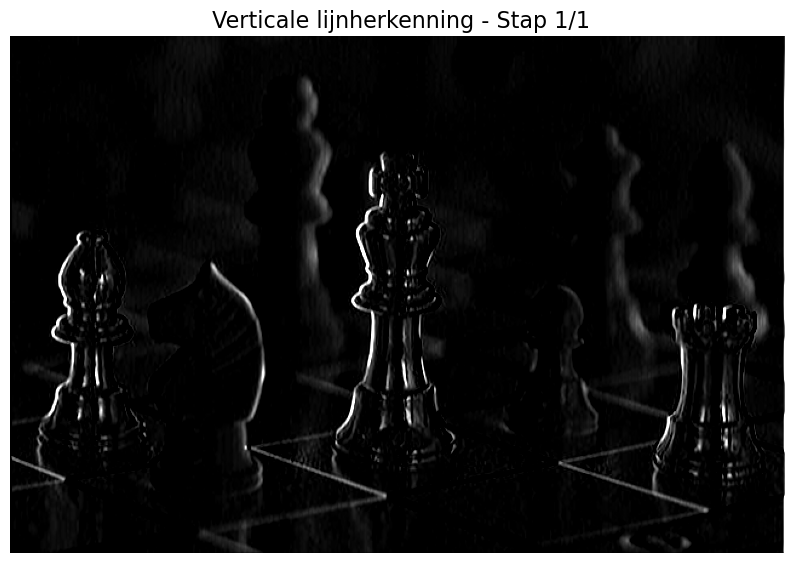

🎉 Verticale lijnherkenning voltooid!

🎯 WAUW! Zie je alle verticale randen oplichten?
✨ Dit is precies hoe je telefoon weet waar objecten zijn!

📱 Toepassingen:
   👻 Snapchat: gebruikt dit om je gezichtsvorm te vinden
   📸 Camera: gebruikt dit voor autofocus op belangrijke objecten
   🚗 Tesla: gebruikt dit om wegmarkeringen te zien
   🔒 Face ID: gebruikt dit om gezichtskenmerken te herkennen

🏆 UITDAGING: Kun jij nu een horizontale edge detector maken?
💡 Hint: Draai het patroon 90 graden! Waar moeten +1 en -1 dan staan?


In [ ]:
# Gezichtsherkenning: verticale lijnen

print("   Deze kernel is de basis van gezichtsherkenningtechnologie.")

# Verticale edge detection kernel (Sobel filter variant)
edge_kernel = np.array([[1,  0, -1],   # Links licht (+1), rechts donker (-1)
                       [1,  0, -1],   # Patroon herhaalt zich verticaal
                       [1,  0, -1]])  # = perfecte verticale rand detector!

print("\n🧠 Logica:")
print("   'Als links licht is (+1) en rechts donker (-1), dan is hier een verticale rand.'")
print("   Dit is hoe Snapchat de zijkant van je gezicht vindt.")

# Laat de kernel zien
show_kernel(edge_kernel, "Verticale lijndetectiekernel")

print("\n🎬 Scanning voor randen zoals een gezichtsherkenning AI... 🤖")

# Edge detection maar 1 keer toepassen (meer zou te veel zijn)
result = apply_conv(img, edge_kernel, iter=1, title_prefix="Verticale lijnherkenning")

print("\n🎯 WAUW! Zie je alle verticale randen oplichten?")
print("✨ Dit is precies hoe je telefoon weet waar objecten zijn!")

print("\n📱 Toepassingen:")
print("   👻 Snapchat: gebruikt dit om je gezichtsvorm te vinden")
print("   📸 Camera: gebruikt dit voor autofocus op belangrijke objecten")  
print("   🚗 Tesla: gebruikt dit om wegmarkeringen te zien")
print("   🔒 Face ID: gebruikt dit om gezichtskenmerken te herkennen")

print("\n🏆 UITDAGING: Kun jij nu een horizontale edge detector maken?")
print("💡 Hint: Draai het patroon 90 graden! Waar moeten +1 en -1 dan staan?")

## 🏆 BONUS CHALLENGE: Maak Je Eigen Filter!

**Tijd om creative te worden!** 🎨 Nu je de basis kent, kun je je eigen unieke filter maken! 

### 🎯 Uitdagingen:
1. **Horizontale Edge Detector:** Vind horizontale lijnen (zoals lippen, wenkbrauwen)
2. **Diagonal Filter:** Laat de foto schuin bewegen
3. **Custom Blur:** Maak je eigen blur-variant
4. **Sharpen Filter:** Maak foto's juist scherper!
5. **Emboss Effect:** Geef je foto een 3D-look

### 💡 Sharpen Filter Hint:
```
Probeer deze kernel:
[[ 0, -1,  0],
 [-1,  5, -1], 
 [ 0, -1,  0]]
```

### 🎨 Emboss Filter Hint:
```
Probeer deze kernel:
[[-2, -1,  0],
 [-1,  1,  1],
 [ 0,  1,  2]]
```

**Experimenteer en laat je creativiteit de vrije loop!** 🚀

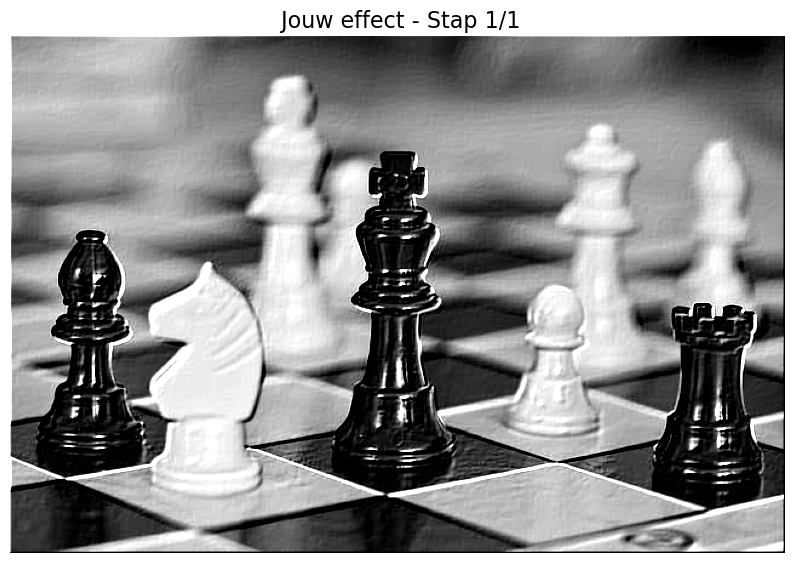

🎉 Jouw effect voltooid!

🎉 Hoe vind je het resultaat?
🔄 Tip: Verander 'chosen_kernel' hierboven naar een andere optie en run opnieuw!
💡 Extra tip: Experimenteer met de getallen in de kernels!


In [25]:
# 🎨 Experimenteer hier

print("🎨 Tijd om je eigen filters te maken!")
print("   Verander de kernel hieronder en kijk wat voor effect je krijgt.")

# JOUW EXPERIMENTEER-RUIMTE - Verander deze kernel!
# Probeer verschillende combinaties van getallen:

# Optie 1: Sharpen Filter (foto scherper maken)
sharpen_kernel = np.array([[ 0, -1,  0],
                          [-1,  5, -1], 
                          [ 0, -1,  0]])

# Optie 2: Emboss Effect (3D look)
emboss_kernel = np.array([[-2, -1,  0],
                         [-1,  1,  1],
                         [ 0,  1,  2]])

# Optie 3: Maak je eigen kernel!
custom_kernel = np.array([[0, 0, 0],
                         [0, 1, 0],    # Verander deze getallen!
                         [0, 0, 0]])

# KIES WELKE KERNEL JE WILT TESTEN (verander de naam hieronder):
chosen_kernel = emboss_kernel  # Verander dit naar jouw keuze!

print(f"\n🔧 Jouw gekozen kernel:")
show_kernel(chosen_kernel, "Jouw Custom Filter")

print("\n🎬 Applying jouw custom filter...")
result = apply_conv(img, chosen_kernel, iter=1, title_prefix="Jouw effect")

print("\n🎉 Hoe vind je het resultaat?")
print("🔄 Tip: Verander 'chosen_kernel' hierboven naar een andere optie en run opnieuw!")
print("💡 Extra tip: Experimenteer met de getallen in de kernels!")

## 📊 Filtergalerij

Laten we alle filters naast elkaar zetten zodat je het verschil goed kunt zien. 

🎨 Maken van filter gallery...


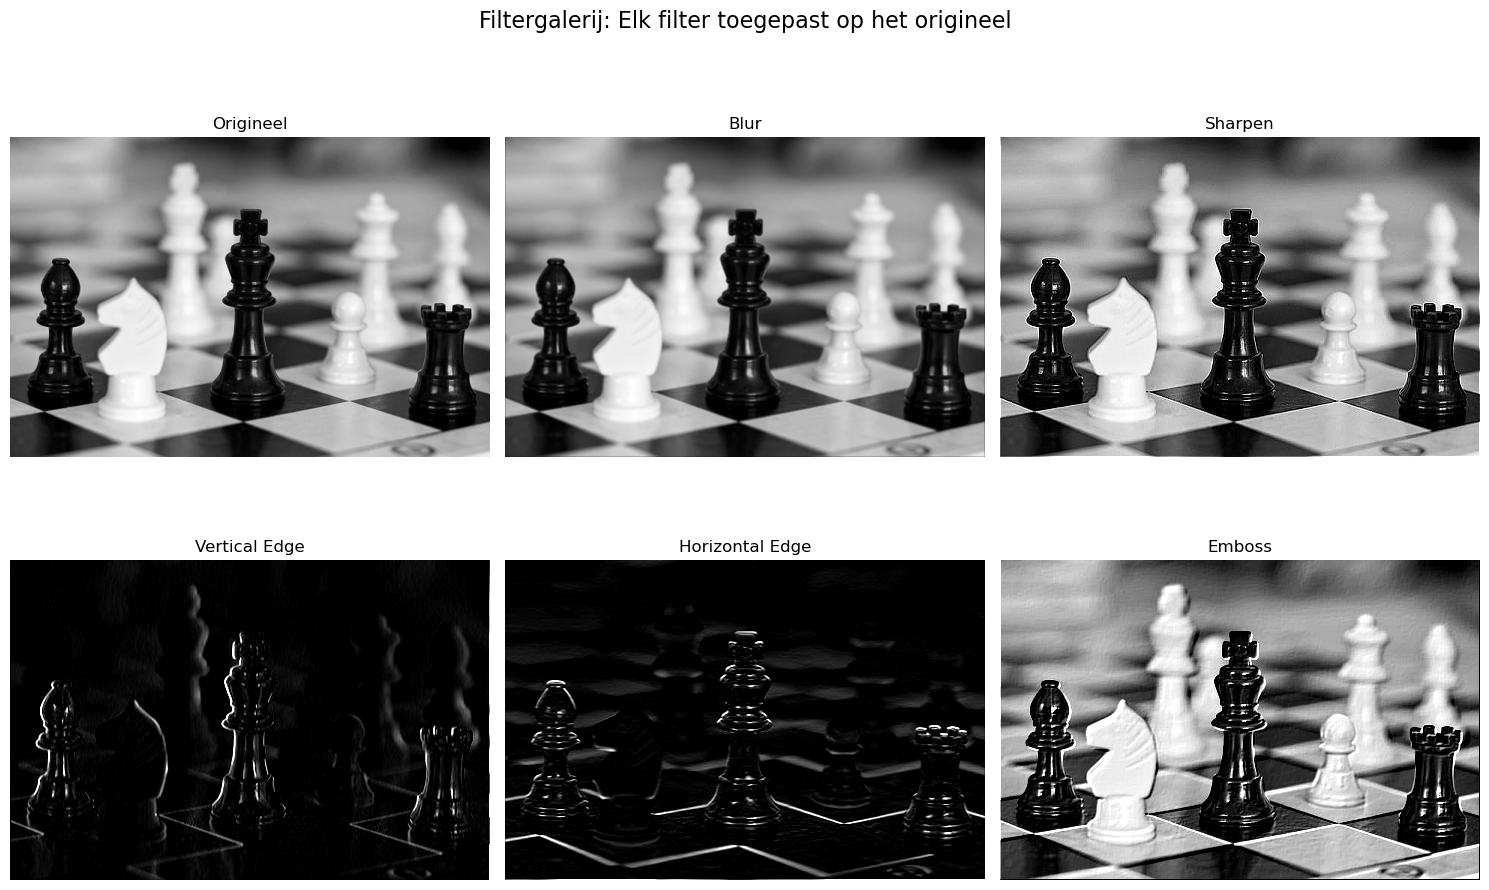

Galerij voltooid!

🤔 Welke filter zou je gebruiken voor:
   📸 Een selfie? (Blur voor zachte huid)
   🏞️ Een landschapsfoto? (Sharpen voor details)
   🎨 Artistieke foto? (Emboss voor 3D-effect)
   🔍 Objecten detecteren? (Edge detection)


In [36]:
# 📊 Filter Gallery - Alle Effecten Naast Elkaar!

def create_filter_gallery(image):
    """Laat alle filters naast elkaar zien - zoals een Instagram filter preview!"""
    
    print("🎨 Maken van filter gallery...")
    
    # Alle kernels definiëren
    kernels = {
        "Origineel": np.array([[0, 0, 0], [0, 1, 0], [0, 0, 0]]),  # Identity (geen verandering)
        "Blur": np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]]) / 16,
        "Sharpen": np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]),
        "Vertical Edge": np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]]),
        "Horizontal Edge": np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]]),
        "Emboss": np.array([[-2, -1, 0], [-1, 1, 1], [0, 1, 2]])
    }
    
    # Maak een 2x3 grid
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Filtergalerij: Elk filter toegepast op het origineel', fontsize=16)
    
    for i, (name, kernel) in enumerate(kernels.items()):
        row, col = divmod(i, 3)
        
        # Pas filter toe
        if name == "Origineel":
            result = image
            # Gebruik originele image range voor normale weergave
            vmin, vmax = image.min(), image.max()
        else:
            # Maak elke keer een NIEUWE copy van de originele afbeelding
            image_tensor = torch.from_numpy(image.copy()).float()
            kernel_tensor = torch.from_numpy(kernel).float()
            result = F.conv2d(image_tensor.reshape(1, 1, *image_tensor.shape),
                            kernel_tensor.reshape(1, 1, *kernel.shape),
                            padding='same').squeeze().numpy()
            
            # Bepaal de juiste colormap range voor dit filter type
            vmin, vmax = image.min(), image.max()
        
        # Toon resultaat met aangepaste colormap
        axes[row, col].imshow(result, cmap='gray', vmin=vmin, vmax=vmax)
        axes[row, col].set_title(name, fontsize=12)
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("Galerij voltooid!")

# Maak de gallery!
create_filter_gallery(img)

print("\n🤔 Welke filter zou je gebruiken voor:")
print("   📸 Een selfie? (Blur voor zachte huid)")
print("   🏞️ Een landschapsfoto? (Sharpen voor details)")
print("   🎨 Artistieke foto? (Emboss voor 3D-effect)")
print("   🔍 Objecten detecteren? (Edge detection)")

## 🎉 Samenvatting: Je Bent Nu Een Filter Expert!

**Gefeliciteerd!** 🏆 Je hebt zojuist geleerd hoe de filters in je favoriete apps werken! Hier is wat je allemaal hebt ontdekt:

### 🧠 Wat Je Hebt Geleerd:

#### 🔍 **Convolutie Basics:**
- Een convolutie is een wiskundige operatie die over je foto "schuift"
- Een **kernel** is het "recept" voor een effect (3x3 matrix met getallen)
- Door de kernel te veranderen, krijg je verschillende effecten

#### 🎭 **Filter Types:**
- **🚀 Movement Filters:** Teleportatie, Anti-gravity, Parkour (pixels verplaatsen)
- **🌟 Blur Filters:** Instagram-style zachte focus effecten
- **⚡ Sharpen Filters:** Maak foto's super scherp en duidelijk
- **🔍 Edge Detection:** Vind randen (basis van gezichtsherkenning!)
- **🎨 Artistic Filters:** Emboss, custom effecten

### 📱 **Real-World Toepassingen:**

#### Social Media:
- **Snapchat:** Gezichtsfilters gebruiken edge detection om je gezicht te vinden
- **Instagram:** Portrait mode gebruikt blur voor achtergrond-vervaging
- **TikTok:** Bewegende effecten gebruiken movement kernels

#### Technologie:
- **📸 Smartphone Camera's:** Automatische scherpstelling en beautify filters
- **🚗 Zelfrijdende Auto's:** Edge detection voor wegmarkeringen en verkeersborden
- **🔒 Face Recognition:** Edge detection voor gezichtsherkenning
- **🎮 Gaming:** Visual effects en real-time graphics

### 🧮 **Wiskundige Magie:**
- **Beweging:** Zet een '1' op de plek waar je naartoe wilt bewegen
- **Blur:** Gebruik gewogen gemiddeldes van buurpixels
- **Edge Detection:** Gebruik +1 en -1 om contrast te vinden
- **Sharpen:** Versterk het midden, verzwak de randen

### 🚀 **Volgende Stappen - Ga Verder Leren!**

#### Voor Beginners:
- **🎨 Experimenteer verder:** Probeer verschillende getallen in kernels
- **📸 Upload meer foto's:** Test filters op verschillende soorten afbeeldingen
- **🔍 Bestudeer resultaten:** Welke filters werken goed bij welke foto's?

#### Voor Gevorderden:
- **🧠 Leer over Deep Learning:** Convoluties zijn de basis van AI voor computer vision
- **📱 Maak je eigen app:** Gebruik bibliotheken zoals OpenCV om je eigen filter-app te maken
- **🎓 Studeer Computer Vision:** Dit is een heel vakgebied in informatica!

#### Cool Resources:
- **OpenCV:** Python bibliotheek voor computer vision
- **Instagram Filter Development:** Leer hoe je echte AR filters maakt
- **Machine Learning:** Convoluties zijn de basis van CNN's (Convolutional Neural Networks)

### 💡 **Pro Tips:**
1. **Kernel Size:** Grotere kernels (5x5, 7x7) geven sterkere effecten
2. **Meerdere Filters:** Je kunt filters combineren voor unieke effecten
3. **Real-time:** Moderne telefoons doen dit alles in real-time!
4. **AI Evolution:** Moderne AI kan automatisch de beste kernels leren

### 🤔 **Denk Na:**
- Hoe zou je een filter maken die kleuren verandert?
- Wat als je een kernel van 5x5 of 7x7 gebruikt?
- Kun je filters combineren voor nog coolere effecten?

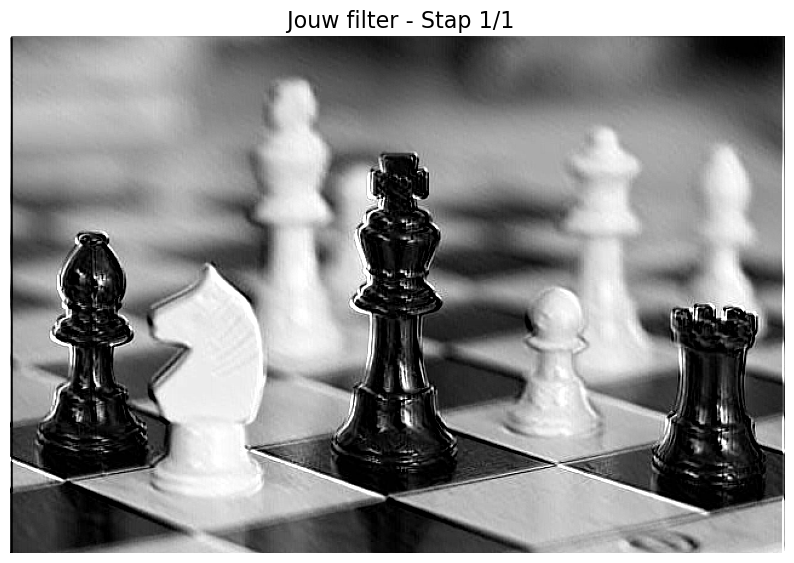

🎉 Jouw filter voltooid!

🎉 GEWELDIG GEDAAN!
🏅 Je hebt nu:
   ✅ Geleerd hoe Snapchat filters werken
   ✅ Je eigen foto-effecten gemaakt
   ✅ De basis van computer vision ontdekt
   ✅ Convoluties gemeesterd!

📱 Fun fact: Grote tech bedrijven zoals Facebook, Google en Apple
   gebruiken precies deze technieken in hun apps!

🚀 Keep experimenting en wie weet maak jij de volgende viral filter!

🎭 CONVOLUTION MASTER CERTIFICATE 🎭
🏆 Gefeliciteerd! Je bent nu een Convolutie Expert!
📸 Deel je coolste filter resultaten met je vrienden!


In [39]:
# 🏆 CHALLENGE: Ontwerp je drooom-filter

print("🎯 LAATSTE UITDAGING: Ontwerp je drooom-filter")
print("   Gebruik alles wat je hebt geleerd om een uniek effect te maken!")

# JOUW ULTIEME FILTER - Maak het zo mooi mogelijk!
# Tip: Je kunt ook grotere kernels proberen (5x5)

dream_filter = np.array([
    [2, 0, 0, 0, -2],
    [0, -1, 0, 1, 0], 
    [0, 0, 1, 0, 0],  # Start met identity - verander dit!
    [0, -1, 0, 1, 0],
    [0, 0, 0, 0, 0]
])

print(f"\n🎨 Jouw Dream Filter:")
show_kernel(dream_filter, "🌟 Jouw Dream Filter")

print("\n🎬 Applying jouw masterpiece...")
final_result = apply_conv(img, dream_filter, iter=1, title_prefix="Jouw filter")

print("\n🎉 GEWELDIG GEDAAN!")
print("🏅 Je hebt nu:")
print("   ✅ Geleerd hoe Snapchat filters werken")
print("   ✅ Je eigen foto-effecten gemaakt") 
print("   ✅ De basis van computer vision ontdekt")
print("   ✅ Convoluties gemeesterd!")

print("\n📱 Fun fact: Grote tech bedrijven zoals Facebook, Google en Apple")
print("   gebruiken precies deze technieken in hun apps!")

print("\n🚀 Keep experimenting en wie weet maak jij de volgende viral filter!")

# Een leuke afsluiting
print("\n" + "="*60)
print("🎭 CONVOLUTION MASTER CERTIFICATE 🎭")
print("="*60)
print("🏆 Gefeliciteerd! Je bent nu een Convolutie Expert!")
print("📸 Deel je coolste filter resultaten met je vrienden!")
print("="*60)